['_RAJ2000_1', '_DEJ2000_1', 'Kcmag', 'Hcmag', 'Jcmag', 'Ktmag', 'K_abs', 'type_1', 'cz', 'JNAME', 'W1mag', 'W2mag', 'W3mag', 'O3Flux', 'class', 'BPTAGN', 'Separation']


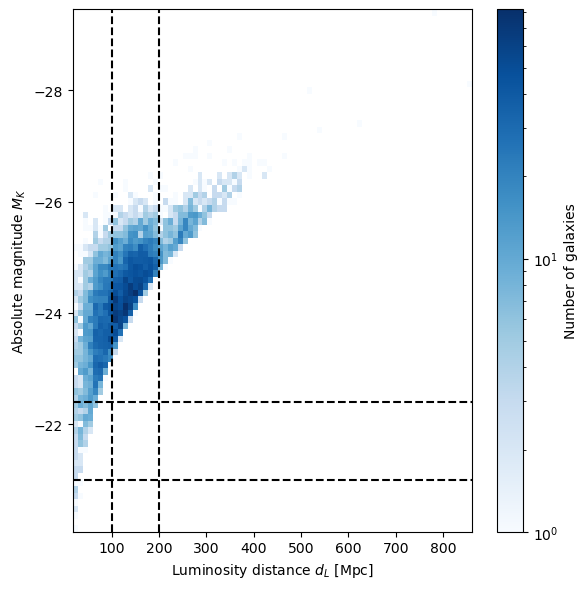

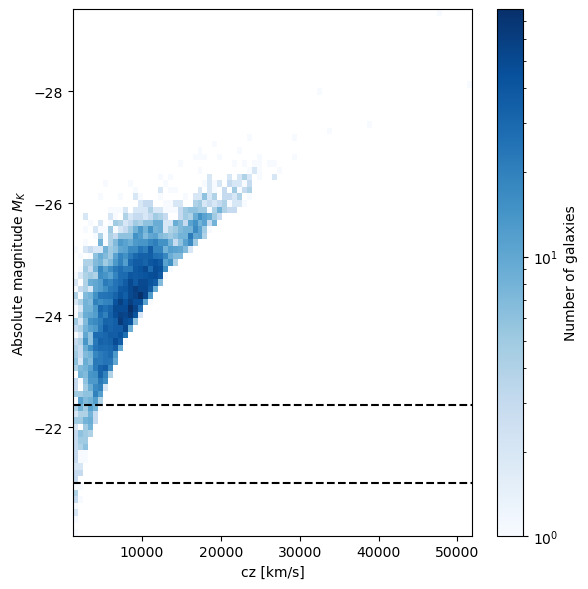


=== Dipole for Full Sample ===
N = 6599 galaxies
RA = 181.30° ± 3.37° (± 2.82° bootstrapped)
Dec = -35.13° ± 3.37° (± 2.64° bootstrapped)
Amplitude = 0.2020 ± 0.0076
Significance = inf sigma (p = 2.22e-63)
Angular separation from Auger = 69.69° ± 2.39°

=== Dipole for 1500-2000 km/s ===
N = 94 galaxies
RA = 127.48° ± 67.50° (± 57.81° bootstrapped)
Dec = -71.72° ± 67.50° (± 11.00° bootstrapped)
Amplitude = 0.3234 ± 0.0487
Significance = -0.52 sigma (p = 6.97e-01)
Angular separation from Auger = 50.18° ± 10.85°

=== Dipole for 2000-2500 km/s ===
N = 85 galaxies
RA = 165.71° ± 12.15° (± 11.37° bootstrapped)
Dec = -21.88° ± 12.15° (± 6.04° bootstrapped)
Amplitude = 0.4889 ± 0.0799
Significance = 4.17 sigma (p = 1.49e-05)
Angular separation from Auger = 59.98° ± 10.27°

=== Dipole for 2500-3000 km/s ===
N = 168 galaxies
RA = 185.89° ± 8.45° (± 6.26° bootstrapped)
Dec = -40.88° ± 8.45° (± 5.65° bootstrapped)
Amplitude = 0.5719 ± 0.0415
Significance = 6.36 sigma (p = 1.01e-10)
Angular separa

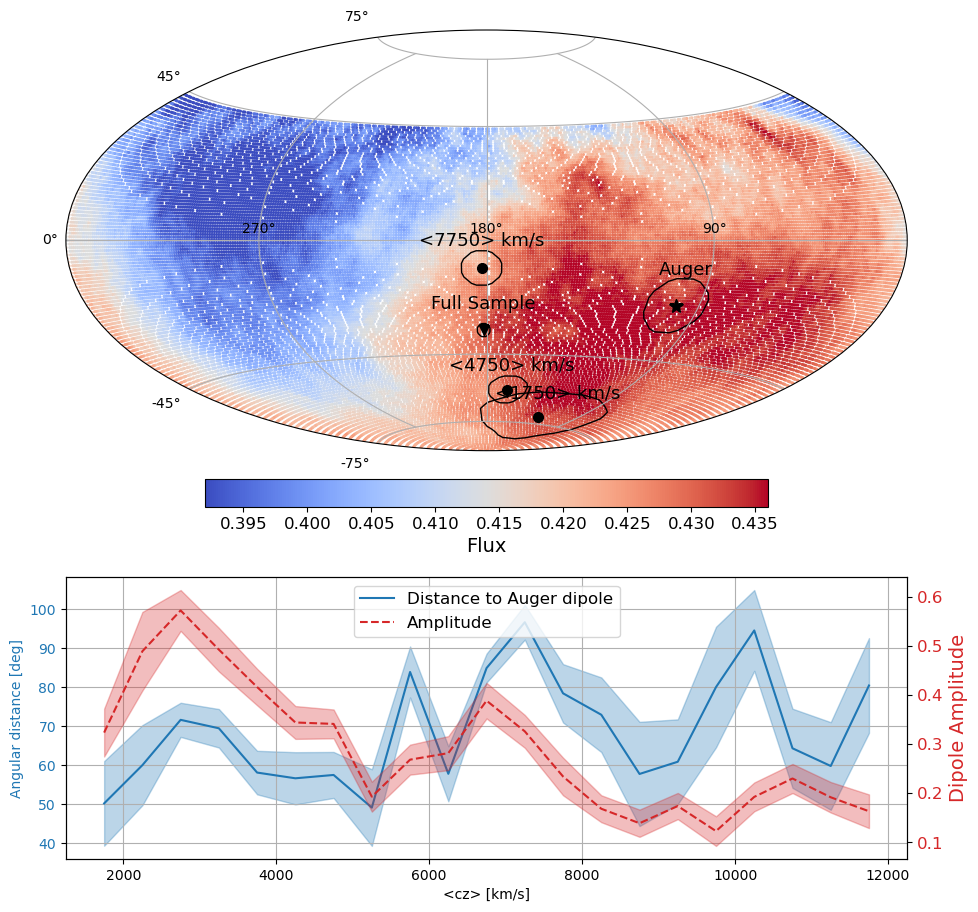

In [3]:
def plot_MK_vs_dL(df):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(6, 6))
    plt.hist2d(
        df["d_L"],
        df["M_K"],
        bins=80,
        cmap='Blues',
        norm=LogNorm()
    )
    # Reference lines
    plt.axvline(x=100, color='k', linestyle='dashed')
    plt.axvline(x=200, color='k', linestyle='dashed')
    plt.axhline(-21, color='k', linestyle='dashed')
    plt.axhline(-22.4, color='k', linestyle='dashed')
    # Labels and style
    plt.xlabel("Luminosity distance $d_L$ [Mpc]")
    plt.ylabel("Absolute magnitude $M_K$")
    #plt.title("Absolute K-band magnitude vs. luminosity distance")
    plt.gca().invert_yaxis()  # brighter = up
    # Colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of galaxies")
    plt.tight_layout()
    plt.show()

### Plot K vs cz
def plot_MK_vs_cz(df):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(6, 6))
    plt.hist2d(
        df["cz"],
        df["M_K"],
        bins=80,
        cmap='Blues',
        norm=LogNorm()
    )
    # Reference lines
    #plt.axvline(x=100, color='k', linestyle='dashed')
    #plt.axvline(x=200, color='k', linestyle='dashed')
    plt.axhline(-21, color='k', linestyle='dashed')
    plt.axhline(-22.4, color='k', linestyle='dashed')
    # Labels and style
    plt.xlabel("cz [km/s]")
    plt.ylabel("Absolute magnitude $M_K$")
    #plt.title("Absolute K-band magnitude vs. luminosity distance")
    plt.gca().invert_yaxis()  # brighter = up
    # Colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of galaxies")
    plt.tight_layout()
    plt.show()

def dipoles_plot(df, plotname, mag_z_plot=True):

    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.special import erfinv
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from astropy.cosmology import Planck18
    cosmo = Planck18
    from matplotlib.patches import Ellipse
    import matplotlib.colors as colors
    from matplotlib.cm import ScalarMappable

    if mag_z_plot: 
        plot_MK_vs_dL(df)
        plot_MK_vs_cz(df)

    RA_all = np.deg2rad(df['RA'])
    Dec_all = np.deg2rad(df['Dec'])
    cz_all = df['cz']
    #weights_all = np.ones(len(RA_all))
    weights_all = 10**(-.4 * df['M_K']) # Use K-band Luminosity as weights

    # === Load flux cataloge ===
    # Load flux data
    file_path = "../data/Auger/flux_a8_lb.dat"
    flux_cat = np.loadtxt(file_path)

    # Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
    flux_dec = flux_cat[:, 0]
    flux_ra = flux_cat[:, 1]
    flux_val = flux_cat[:, 2]

    # Convert to radians
    ra_rad = np.radians(flux_ra)
    dec_rad = np.radians(flux_dec)

    # Shift RA to put RA=0° on right edge, increase leftward
    ra_shifted = np.remainder(ra_rad + np.pi, 2 * np.pi)
    ra_shifted[ra_shifted > np.pi] -= 2 * np.pi
    ra_shifted = -ra_shifted  # flip to increase leftward


    # === Define cz bins ===
    cz_i, cz_f, cz_step = 1500, 12000, 500
    cz_bins = [(cz, cz + 500) for cz in range(cz_i, cz_f, cz_step)]
    cz_bins.insert(0, (cz_i, cz_f))  # Add full sample as first bin

    # === Setup colors and storage ===
    #n_bins = len(cz_bins)
    dipole_results = {}
    # Normalize cz range for colormap
    cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
    cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))  # exclude full sample from colormap range
    cmap = cm.cividis  # or try 'viridis', 'turbo', 'cividis'
    #import seaborn as sns
    #cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

    # === Auger reference dipole ===
    auger_RA = 100.0
    auger_Dec = -24.0
    auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
    #auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction
    auger_error_ra_deg = 10.0  # Uncertainty in RA
    auger_error_dec_deg = 13.0  # Uncertainty in Dec

    # === Loop through bins ===
    for i, (cz_min, cz_max) in enumerate(cz_bins):
        label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
        cz_mid = 0.5 * (cz_min + cz_max)
        color = 'k' if i == 0 else cmap(cz_norm(cz_mid))  # gray for full sample, colormap for bins

        # Filter galaxies
        mask = (cz_all > cz_min) & (cz_all < cz_max)
        RA = np.array(RA_all[mask])
        Dec = np.array(Dec_all[mask])
        weights = np.array(weights_all[mask])

        if len(RA) < 10:
            print(f"Skipping {label} — too few galaxies ({len(RA)})")
            continue

        W = np.sum(weights)

        # === 2D Rayleigh dipole ===
        a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
        b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
        r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
        #phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

        # === 3D dipole direction ===
        x = np.cos(Dec) * np.cos(RA)
        y = np.cos(Dec) * np.sin(RA)
        z = np.sin(Dec)
        X = np.sum(weights * x)
        Y = np.sum(weights * y)
        Z = np.sum(weights * z)
        norm = np.sqrt(X**2 + Y**2 + Z**2)
        X /= norm
        Y /= norm
        Z /= norm

        dipole_amp = norm / W
        alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
        delta_d = np.arcsin(Z) * 180 / np.pi

        # === Uncertainty and significance ===
        Weff = W**2 / np.sum(weights**2)                # Effective weight
        sigma_r = np.sqrt(2 / Weff)                     # Uncertainty in radial component
        sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)   # Rough approximation
        sigma_dec_deg = sigma_phi_deg                   # rough approximation
        P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)     # Rayleigh p-value
        Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)  # Gaussian significance

        # === Angular separation from Auger dipole ===
        dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
        separation = dip_coord.separation(auger_coord).deg

        # === Store results ===
        dipole_results[label] = {
            'RA': alpha_d,
            'Dec': delta_d,
            'r_alpha': r_alpha,
            'd_perp': dipole_amp,
            'sigma_r': sigma_r,
            'sigma_phi': sigma_phi_deg,
            'sigma_dec': sigma_dec_deg,
            'Z': Zsig,
            'P': P_rayleigh,
            'separation': separation,
            'N': len(RA),
            'color': color
        }

        # === Bootstrap dipole errors ===
        n_bootstrap = 500
        dipole_ras = []
        dipole_decs = []
        dipole_amps_bs = []
        sep_bs = []

        for _ in range(n_bootstrap):
            indices = np.random.choice(len(RA), size=len(RA), replace=True)
            RA_bs = RA[indices]
            Dec_bs = Dec[indices]
            weights_bs = weights[indices]


            x = np.cos(Dec_bs) * np.cos(RA_bs)
            y = np.cos(Dec_bs) * np.sin(RA_bs)
            z = np.sin(Dec_bs)

            X = np.sum(weights_bs * x)
            Y = np.sum(weights_bs * y)
            Z = np.sum(weights_bs * z)
            norm = np.sqrt(X**2 + Y**2 + Z**2)
            X /= norm
            Y /= norm
            Z /= norm

            amp = norm / np.sum(weights_bs)
            ra_bs = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
            dec_bs = np.arcsin(Z) * 180 / np.pi

            dipole_ras.append(ra_bs)
            dipole_decs.append(dec_bs)
            dipole_amps_bs.append(amp)

            # Angular separation with Auger dipole
            dip_coord_bs = SkyCoord(ra=ra_bs * u.deg, dec=dec_bs * u.deg, frame='icrs')
            sep = dip_coord_bs.separation(auger_coord).deg
            sep_bs.append(sep)

        # === Bootstrap uncertainties ===
        sigma_ra_boot = np.std(dipole_ras)
        sigma_dec_boot = np.std(dipole_decs)
        sigma_amp_boot = np.std(dipole_amps_bs)
        sigma_sep_boot = np.std(sep_bs)

        dipole_results[label].update({
            'sigma_ra_boot': sigma_ra_boot,
            'sigma_dec_boot': sigma_dec_boot,
            'sigma_amp_boot': sigma_amp_boot,
            'sigma_sep_boot': sigma_sep_boot
        })

        # === Print result ===
        print(f"\n=== Dipole for {label} ===")
        print(f"N = {len(RA)} galaxies")
        print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}° (± {sigma_ra_boot:.2f}° bootstrapped)")
        print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}° (± {sigma_dec_boot:.2f}° bootstrapped)")
        print(f"Amplitude = {dipole_amp:.4f} ± {sigma_amp_boot:.4f}")
        print(f"Significance = {Zsig:.2f} sigma (p = {P_rayleigh:.2e})")
        print(f"Angular separation from Auger = {separation:.2f}° ± {sigma_sep_boot:.2f}°")


    # === Set up top and bottom subplots ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    # === Set fontsizrs ===

    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    # === Configure Hammer (Top) Axis ===
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax_top.set_xticks(xticks_rad)
    ax_top.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax_top.set_yticks(yticks_rad)
    ax_top.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Plot flux on sky ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    # === Remove NaNs from flux_val and corresponding positions ===
    mask = np.isfinite(flux_val)
    ra_shifted = ra_shifted[mask]
    dec_rad = np.radians(flux_dec[mask])
    flux_val = flux_val[mask]
    sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for flux
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=.05, fraction=0.05)
    cbar_flux.set_label("Flux")

    # === Plot dipoles ===
    for label, res in dipole_results.items():
        
        if label not in [f"{cz_min}-{cz_max} km/s" for cz_min, cz_max in [(1500, 2000), (4500, 5000), (7500, 8000)]] + ['Full Sample']:
            continue

        ra_rad = np.deg2rad(res['RA'])
        dec_rad = np.deg2rad(res['Dec'])
        ra_plot = -ra_rad + np.pi  # <- RA increases right to left
        color = res['color']
        amp = res['d_perp']

        marker = 'o' if label != 'Full Sample' else 'v'
        ax_top.plot(ra_plot, dec_rad, marker, color='k', label=label, markersize=7)

        ellipse = Ellipse(
            (ra_plot, dec_rad),
            width=2*np.deg2rad(res['sigma_ra_boot']),
            height=2*np.deg2rad(res['sigma_dec_boot']),
            angle=0,
            edgecolor='k',
            facecolor='none',
            alpha=1,
            transform=ax_top.transData
        )
        ax_top.add_patch(ellipse)

        #if label == 'Full Sample':
        czmid = float(label.split('-')[0]) + 250 if label != 'Full Sample' else label
        ax_top.text(ra_plot, dec_rad + 0.15, f'<{int(czmid)}> km/s' if czmid!='Full Sample' else 'Full Sample'\
                    , ha='center', color='k', size=13)

    # Auger point and ellipse
    auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
    auger_dec_rad = np.deg2rad(auger_Dec)
    ax_top.plot(auger_ra_plot, auger_dec_rad, 'k*', markersize=10, label='Auger Dipole')
    ellipse = Ellipse(
        (auger_ra_plot, auger_dec_rad),
        width=2*np.deg2rad(auger_error_dec_deg),
        height=2*np.deg2rad(auger_error_ra_deg),
        angle=0,
        edgecolor='k',
        facecolor='none',
        alpha=1,
        transform=ax_top.transData
    )
    ax_top.add_patch(ellipse)
    ax_top.text(auger_ra_plot, auger_dec_rad + 0.2, "Auger", ha='center', color='k', size=13)
    #ax_top.set_title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)

    # # Vertical cz colorbar
    # sm = ScalarMappable(cmap=cmap, norm=cz_norm)
    # sm.set_array([])
    # cbar_cz = fig.colorbar(sm, ax=ax_top, orientation='vertical', pad=0.01, fraction=0.025)
    # cbar_cz.set_label("<cz> [km/s]")

    # === Bottom Plot: Dipole amp & separation ===
    cz_bin_centers = []
    angular_separations = []
    dipole_amps = []
    ang_diam_dists = []

    for label, res in dipole_results.items():
        if label == "Full Sample":
            continue

        cz_mid = float(label.split('-')[0]) + cz_step/2
        cz_bin_centers.append(cz_mid)
        angular_separations.append(res['separation'])
        dipole_amps.append(res['d_perp'])

        cosmo = Planck18
        z = cz_mid / 3e5
        d_ang = cosmo.angular_diameter_distance(z).value
        ang_diam_dists.append(d_ang)

    x = cz_bin_centers
    sep_errors = [dipole_results[label]['sigma_sep_boot'] for label in dipole_results if label != "Full Sample"]
    amp_errors = [dipole_results[label]['sigma_amp_boot'] for label in dipole_results if label != "Full Sample"]

    # Angular separation on left y-axis
    color1 = 'C0'
    ax_bottom.fill_between(x, np.array(angular_separations)-np.array(sep_errors), np.array(angular_separations)+np.array(sep_errors), color=color1, alpha=0.3)
    ln1 = ax_bottom.plot(x, angular_separations, ls='-', color=color1, label='Distance to Auger dipole')
    ax_bottom.set_ylabel("Angular distance [deg]", color=color1)
    ax_bottom.tick_params(axis='y', labelcolor=color1)
    ax_bottom.grid(True)

    # Dipole amplitude on right y-axis
    ax2 = ax_bottom.twinx()
    color2 = 'C3'
    ax2.fill_between(x, np.array(dipole_amps)-np.array(amp_errors), np.array(dipole_amps)+np.array(amp_errors), color=color2, alpha=0.3)
    ln2 = ax2.plot(x, dipole_amps, ls='--', color=color2, label='Amplitude')
    ax2.set_ylabel("Dipole Amplitude", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # X-axis
    ax_bottom.set_xlabel("<cz> [km/s]")

    # Legend
    lines = ln1 + ln2  # flatten the list of lines
    labels = [l.get_label() for l in lines]
    ax_bottom.legend(lines, labels, loc='upper center')


    #ax_bottom.set_title("Dipole Angular Separation and Amplitude vs cz")
    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        #'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    plt.tight_layout()
    plt.savefig(plotname, dpi=300)
    plt.show()
    
def luminosity_distance_from_z(z_array, H0=70, Om0=0.3, use_planck=True):
    """
    Return luminosity distance in Mpc for an array of redshifts.
    If use_planck=True, uses astropy's Planck18 cosmology.
    Otherwise uses FlatLambdaCDM with supplied H0 (km/s/Mpc) and Om0.
    """
    from astropy.cosmology import FlatLambdaCDM, Planck18
    import astropy.units as u
    import numpy as np  
    if use_planck:
        cosmo = Planck18
    else:
        cosmo = FlatLambdaCDM(H0=H0*u.km/u.s/u.Mpc, Om0=Om0)
    return cosmo.luminosity_distance(z_array).to(u.Mpc)

def read_agns(filename='../data/2MRSxWISExZAW2019opticalAGNs_OIIIFlux.txt', mincz=1200):

    from astropy.io import ascii

    data = ascii.read(filename)

    print(data.keys())

    data = data[data['cz']>mincz]

    data = data[(data['BPTAGN'] == 1)|(data['class'] == 1)]  # Filter for BPT AGNs and WISE AGNs

    data = data[data['_DEJ2000_1'] < 45.]

    data['RA'] = data['_RAJ2000_1']
    data['Dec'] = data['_DEJ2000_1']

    data['d_L'] = luminosity_distance_from_z(data['cz']/3e5).value  # in Mpc
    #data['M_K'] = data['Kmag'] - 5 * np.log10(df["d_L"]) - 25
    data['M_K'] = data['K_abs']
    
    return data

agns = read_agns()

dipoles_plot(agns, plotname='../plots/plot1_AGNs_paper1.png')


### Both in same plot

/tmp/ipykernel_11750/3556107526.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 144134


/tmp/ipykernel_11750/3556107526.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


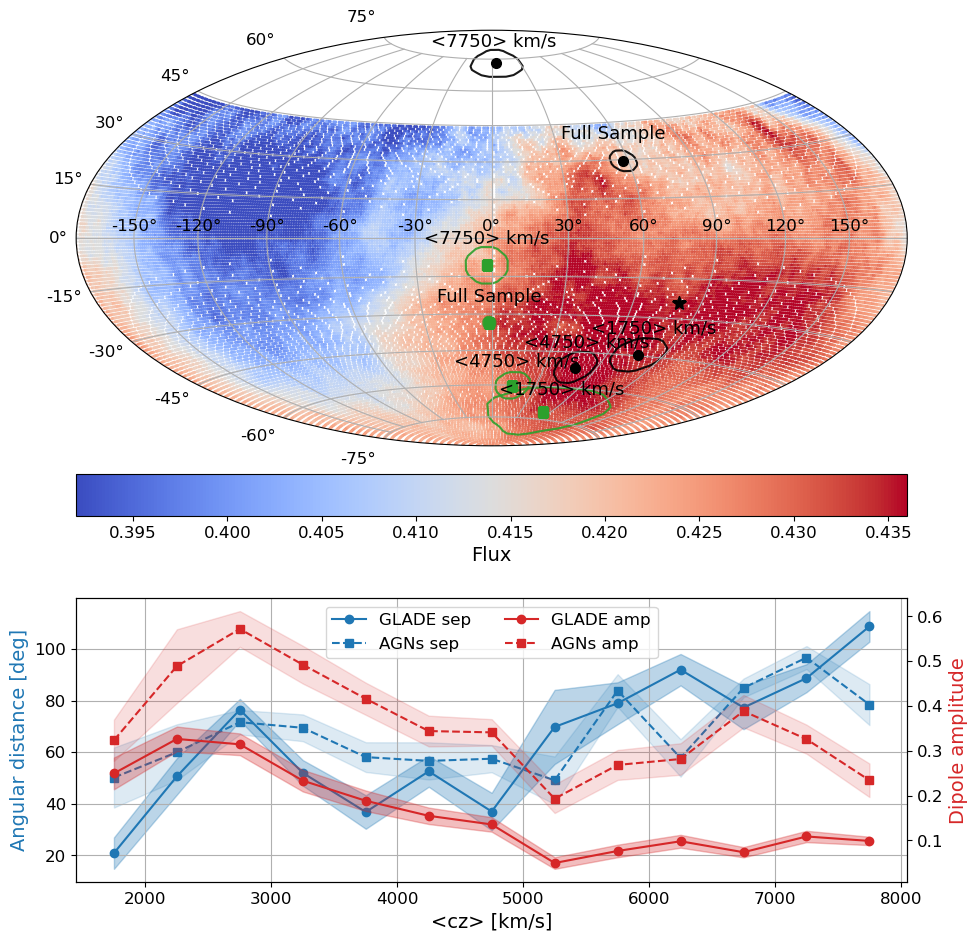

In [6]:
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    import pandas as pd
    import numpy as np
    
    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df


def dipoles_plot_compare(df1, df2, labels=('Sample 1', 'Sample 2'), plotname='compare.png', mag_z_plot=True):
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.special import erfinv
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from astropy.cosmology import FlatLambdaCDM
    from matplotlib.patches import Ellipse

    def compute_dipoles(df, cmap_name):
        RA_all = np.deg2rad(np.asarray(df['RA']))
        Dec_all = np.deg2rad(np.asarray(df['Dec']))
        cz_all = np.asarray(df['cz'])
        weights_all = np.asarray(10**(-.4 * df['M_K']))

        cz_i, cz_f, cz_step = 1500, 8000, 500
        cz_bins = [(cz, cz + 500) for cz in range(cz_i, cz_f, cz_step)]
        cz_bins.insert(0, (cz_i, cz_f))
        cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]

        cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))
        cmap = cm.get_cmap(cmap_name)

        auger_RA, auger_Dec = 100.0, -24.0
        auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')

        dipole_results = {}

        for i, (cz_min, cz_max) in enumerate(cz_bins):
            label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
            cz_mid = 0.5 * (cz_min + cz_max)
            color = 'k' if i == 0 else cmap(cz_norm(cz_mid))

            mask = (cz_all > cz_min) & (cz_all < cz_max)
            RA, Dec, weights = RA_all[mask], Dec_all[mask], weights_all[mask]
            if len(RA) < 10:
                continue

            W = np.sum(weights)
            x, y, z = np.cos(Dec)*np.cos(RA), np.cos(Dec)*np.sin(RA), np.sin(Dec)
            X, Y, Z = np.sum(weights*x), np.sum(weights*y), np.sum(weights*z)
            norm = np.sqrt(X**2 + Y**2 + Z**2)
            X, Y, Z = X/norm, Y/norm, Z/norm

            dipole_amp = norm / W
            alpha_d = np.degrees(np.arctan2(Y, X) % (2 * np.pi))
            delta_d = np.degrees(np.arcsin(Z))

            dip_coord = SkyCoord(ra=alpha_d*u.deg, dec=delta_d*u.deg, frame='icrs')
            separation = dip_coord.separation(auger_coord).deg

            # Bootstrap errors
            n_bootstrap = 500
            dipole_ras, dipole_decs, dipole_amps_bs, sep_bs = [], [], [], []
            for _ in range(n_bootstrap):
                idx = np.random.choice(len(RA), len(RA), replace=True)
                RA_bs, Dec_bs, w_bs = RA[idx], Dec[idx], weights[idx]
                x, y, z = np.cos(Dec_bs)*np.cos(RA_bs), np.cos(Dec_bs)*np.sin(RA_bs), np.sin(Dec_bs)
                X, Y, Z = np.sum(w_bs*x), np.sum(w_bs*y), np.sum(w_bs*z)
                norm = np.sqrt(X**2 + Y**2 + Z**2)
                X, Y, Z = X/norm, Y/norm, Z/norm

                amp = norm / np.sum(w_bs)
                ra_bs = np.degrees(np.arctan2(Y, X) % (2 * np.pi))
                dec_bs = np.degrees(np.arcsin(Z))
                dipole_ras.append(ra_bs)
                dipole_decs.append(dec_bs)
                dipole_amps_bs.append(amp)

                dip_coord_bs = SkyCoord(ra=ra_bs*u.deg, dec=dec_bs*u.deg)
                sep_bs.append(dip_coord_bs.separation(auger_coord).deg)

            dipole_results[label] = {
                'RA': alpha_d, 'Dec': delta_d, 'd_perp': dipole_amp,
                'separation': separation, 'color': color,
                'sigma_ra_boot': np.std(dipole_ras),
                'sigma_dec_boot': np.std(dipole_decs),
                'sigma_amp_boot': np.std(dipole_amps_bs),
                'sigma_sep_boot': np.std(sep_bs)
            }

        return dipole_results

    # === Load flux map ===
    flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
    flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]
    ra_rad = np.radians(flux_ra)
    dec_rad = np.radians(flux_dec)
    ra_shifted = np.remainder(ra_rad + np.pi, 2*np.pi)
    ra_shifted[ra_shifted > np.pi] -= 2*np.pi
    ra_shifted = -ra_shifted

    # === Compute both dipole sets ===
    dipoles_1 = compute_dipoles(df1, 'cividis')
    dipoles_2 = compute_dipoles(df2, 'plasma')

    # === Plot setup ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=.05)
    cbar_flux.set_label("Flux")

    # Auger dipole
    auger_RA, auger_Dec = 100.0, -24.0
    auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
    auger_dec_plot = np.deg2rad(auger_Dec)
    ax_top.plot(auger_ra_plot, auger_dec_plot, 'k*', markersize=10, label='Auger Dipole')

    # === Function for plotting dipoles with ellipses ===
    def plot_dipoles(ax, dipoles, marker, label_prefix, color):
        for label, res in dipoles.items():
            if label not in [f"{cz_min}-{cz_max} km/s" for cz_min, cz_max in [(1500,2000),(4500,5000),(7500,8000)]] + ['Full Sample'] + ['Auger']:
                continue
            ra_plot = -np.deg2rad(res['RA']) + np.pi
            dec_plot = np.deg2rad(res['Dec'])
            ax.plot(ra_plot, dec_plot, marker, color=color, label=f"{label_prefix} {label}", markersize=7)
            czmid = float(label.split('-')[0]) + 250 if label != 'Full Sample' else label
            if label == 'Full Sample': text = 'Full Sample'
            elif label == 'Auger': text = 'Auger'
            elif label not in ['Full Sample', 'Auger']:
                text = f'<{int(czmid)}> km/s' if czmid!='Full Sample' else 'Full Sample'
            ax.text(ra_plot, dec_plot + 0.15, text, ha='center', color='k', size=13)
            ellipse = Ellipse(
                (ra_plot, dec_plot),
                width=2*np.deg2rad(res['sigma_ra_boot']),
                height=2*np.deg2rad(res['sigma_dec_boot']),
                edgecolor=color, facecolor='none', lw=1.5, alpha=0.9, transform=ax.transData
            )
            ax.add_patch(ellipse)

    plot_dipoles(ax_top, dipoles_1, 'o', labels[0], color='k')
    plot_dipoles(ax_top, dipoles_2, 's', labels[1], color='C02')

    #ax_top.legend(loc='lower left', fontsize=9)

    # === Bottom plot: amplitude and separation ===
    def extract_arrays(dipoles):
        czs, seps, amps, sep_errs, amp_errs = [], [], [], [], []
        for label, res in dipoles.items():
            if label == "Full Sample": continue
            cz_mid = float(label.split('-')[0]) + 250
            czs.append(cz_mid)
            seps.append(res['separation'])
            amps.append(res['d_perp'])
            sep_errs.append(res['sigma_sep_boot'])
            amp_errs.append(res['sigma_amp_boot'])
        return np.array(czs), np.array(seps), np.array(amps), np.array(sep_errs), np.array(amp_errs)

    cz1, sep1, amp1, sep_err1, amp_err1 = extract_arrays(dipoles_1)
    cz2, sep2, amp2, sep_err2, amp_err2 = extract_arrays(dipoles_2)

    ax_bottom.fill_between(cz1, sep1-sep_err1, sep1+sep_err1, color='C0', alpha=0.3)
    ax_bottom.plot(cz1, sep1, 'o-', color='C0', label=f'{labels[0]} sep')
    ax_bottom.fill_between(cz2, sep2-sep_err2, sep2+sep_err2, color='C0', alpha=0.15)
    ax_bottom.plot(cz2, sep2, 's--', color='C0', label=f'{labels[1]} sep')

    ax2 = ax_bottom.twinx()
    ax2.fill_between(cz1, amp1-amp_err1, amp1+amp_err1, color='C3', alpha=0.3)
    ax2.plot(cz1, amp1, 'o-', color='C3', label=f'{labels[0]} amp')
    ax2.fill_between(cz2, amp2-amp_err2, amp2+amp_err2, color='C3', alpha=0.15)
    ax2.plot(cz2, amp2, 's--', color='C3', label=f'{labels[1]} amp')

    ax_bottom.set_xlabel("<cz> [km/s]")
    ax_bottom.set_ylabel("Angular distance [deg]", color='C0')
    ax2.set_ylabel("Dipole amplitude", color='C3')
    ax_bottom.grid(True)

    # Merge legends
    lines, labels_all = [], []
    for ax in [ax_bottom, ax2]:
        h, l = ax.get_legend_handles_labels()
        lines += h; labels_all += l
    ax_bottom.legend(lines, labels_all, loc='upper center', ncol=2)

    plt.tight_layout()
    plt.savefig(plotname, dpi=300)
    plt.show()

# Load Data
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
df = read_GLADE(cols)
dipoles_plot_compare(
    df, agns,
    labels=('GLADE', 'AGNs'),
    plotname='../plots/compare_dipoles.png'
)


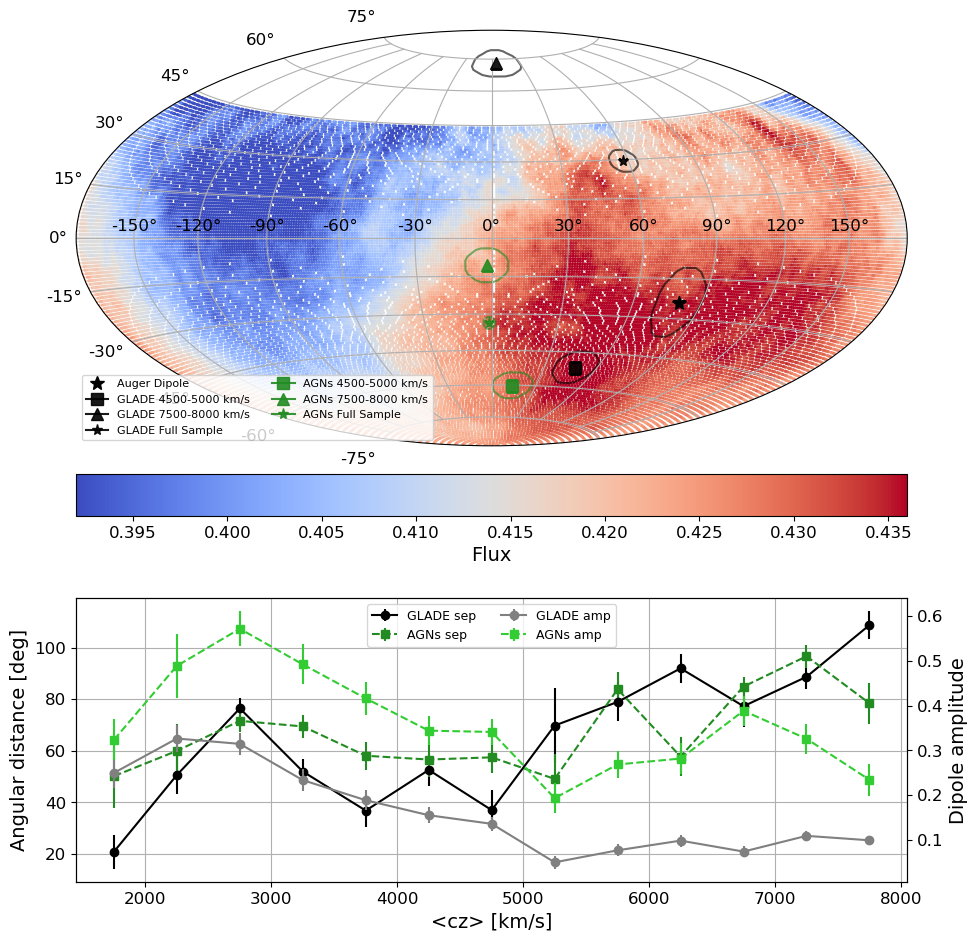

In [7]:
def dipoles_plot_compare(df1, df2, labels=('Sample 1', 'Sample 2'), plotname='compare.png'):
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from matplotlib.patches import Ellipse
    import matplotlib.colors as mcolors

    def to_numpy_safe(x):
        return np.asarray(x)

    def compute_dipoles(df, color):
        RA_all = np.deg2rad(to_numpy_safe(df['RA']))
        Dec_all = np.deg2rad(to_numpy_safe(df['Dec']))
        cz_all = to_numpy_safe(df['cz'])
        weights_all = to_numpy_safe(10**(-.4 * df['M_K']))

        cz_bins = [
            (1500, 2000), (2000, 2500),
            (2500, 3000), (3000, 3500), (3500, 4000),
            (4000, 4500), (4500, 5000),
            (5000, 5500), (5500, 6000), (6000, 6500),
            (6500, 7000), (7000, 7500), (7500, 8000),
            (1500, 8000)  # Full sample
        ]

        auger_RA, auger_Dec = 100.0, -24.0
        auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')

        dipole_results = {}
        for cz_min, cz_max in cz_bins:
            label = "Full Sample" if (cz_min, cz_max) == (1500, 8000) else f"{cz_min}-{cz_max} km/s"
            cz_mid = 0.5 * (cz_min + cz_max)

            mask = (cz_all > cz_min) & (cz_all < cz_max)
            RA, Dec, weights = RA_all[mask], Dec_all[mask], weights_all[mask]
            if len(RA) < 10:
                continue

            W = np.sum(weights)
            x, y, z = np.cos(Dec)*np.cos(RA), np.cos(Dec)*np.sin(RA), np.sin(Dec)
            X, Y, Z = np.sum(weights*x), np.sum(weights*y), np.sum(weights*z)
            norm = np.sqrt(X**2 + Y**2 + Z**2)
            X, Y, Z = X/norm, Y/norm, Z/norm

            dipole_amp = norm / W
            alpha_d = np.degrees(np.arctan2(Y, X) % (2 * np.pi))
            delta_d = np.degrees(np.arcsin(Z))

            dip_coord = SkyCoord(ra=alpha_d*u.deg, dec=delta_d*u.deg, frame='icrs')
            separation = dip_coord.separation(auger_coord).deg

            # Bootstrap errors
            n_bootstrap = 300
            dipole_ras, dipole_decs, dipole_amps_bs, sep_bs = [], [], [], []
            for _ in range(n_bootstrap):
                idx = np.random.choice(len(RA), len(RA), replace=True)
                RA_bs, Dec_bs, w_bs = RA[idx], Dec[idx], weights[idx]
                x, y, z = np.cos(Dec_bs)*np.cos(RA_bs), np.cos(Dec_bs)*np.sin(RA_bs), np.sin(Dec_bs)
                X, Y, Z = np.sum(w_bs*x), np.sum(w_bs*y), np.sum(w_bs*z)
                norm = np.sqrt(X**2 + Y**2 + Z**2)
                X, Y, Z = X/norm, Y/norm, Z/norm
                amp = norm / np.sum(w_bs)
                ra_bs = np.degrees(np.arctan2(Y, X) % (2 * np.pi))
                dec_bs = np.degrees(np.arcsin(Z))
                dipole_ras.append(ra_bs)
                dipole_decs.append(dec_bs)
                dipole_amps_bs.append(amp)
                dip_coord_bs = SkyCoord(ra=ra_bs*u.deg, dec=dec_bs*u.deg)
                sep_bs.append(dip_coord_bs.separation(auger_coord).deg)

            dipole_results[label] = {
                'RA': alpha_d, 'Dec': delta_d, 'd_perp': dipole_amp,
                'separation': separation, 'color': color,
                'cz_mid': cz_mid,
                'sigma_ra_boot': np.std(dipole_ras),
                'sigma_dec_boot': np.std(dipole_decs),
                'sigma_amp_boot': np.std(dipole_amps_bs),
                'sigma_sep_boot': np.std(sep_bs)
            }
        return dipole_results

    # === Background flux map ===
    flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
    flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]
    ra_rad = np.radians(flux_ra)
    dec_rad = np.radians(flux_dec)
    ra_shifted = np.remainder(ra_rad + np.pi, 2*np.pi)
    ra_shifted[ra_shifted > np.pi] -= 2*np.pi
    ra_shifted = -ra_shifted

    # === Compute dipoles ===
    dipoles_1 = compute_dipoles(df1, 'k')
    dipoles_2 = compute_dipoles(df2, 'forestgreen')

    # === Markers for selected bins ===
    selected_bins = ["Full Sample", "1500-2500 km/s", "4500-5000 km/s", "7500-8000 km/s"]
    marker_map = {
        "Full Sample": "*",
        "1500-2500 km/s": "o",
        "4500-5000 km/s": "s",
        "7500-8000 km/s": "^"
    }

    # === Plot setup ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=.05)
    cbar_flux.set_label("Flux")

    # Auger dipole
    auger_RA = 100.0
    auger_Dec = -24.0
    auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
    #auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction
    auger_error_ra_deg = 10.0  # Uncertainty in RA
    auger_error_dec_deg = 13.0  # Uncertainty in Dec
    ax_top.plot(-np.deg2rad(auger_RA)+np.pi, np.deg2rad(auger_Dec), 'k*', markersize=10, label='Auger Dipole')
    ellipse = Ellipse(
        (-np.deg2rad(auger_RA)+np.pi, np.deg2rad(auger_Dec)),
        width=2*np.deg2rad(auger_error_ra_deg),
        height=2*np.deg2rad(auger_error_dec_deg),
        edgecolor='k', facecolor='none',
        lw=1.5, alpha=0.6, transform=ax_top.transData
    )
    ax_top.add_patch(ellipse)
    
    # === Plot selected dipoles ===
    def plot_selected_dipoles(ax, dipoles, label_prefix):
        for label, res in dipoles.items():
            if label not in selected_bins:
                continue
            ra_plot = -np.deg2rad(res['RA']) + np.pi
            dec_plot = np.deg2rad(res['Dec'])
            marker = marker_map[label]
            ax.plot(ra_plot, dec_plot, marker=marker, color=res['color'],
                    label=f"{label_prefix} {label}", markersize=8, alpha=0.9)
            # Bootstrap ellipse
            ellipse = Ellipse(
                (ra_plot, dec_plot),
                width=2*np.deg2rad(res['sigma_ra_boot']),
                height=2*np.deg2rad(res['sigma_dec_boot']),
                edgecolor=res['color'], facecolor='none',
                lw=1.5, alpha=0.6, transform=ax.transData
            )
            ax.add_patch(ellipse)
            # Annotate cz
            # ax.text(ra_plot, dec_plot + np.deg2rad(5),
            #         f"cz={int(res['cz_mid'])}",
            #         color=res['color'], fontsize=8,
            #         ha='center', va='bottom')

    plot_selected_dipoles(ax_top, dipoles_1, labels[0])
    plot_selected_dipoles(ax_top, dipoles_2, labels[1])
    ax_top.legend(loc='lower left', fontsize=8, ncol=2)

    # === Bottom: full cz range ===
    def extract_arrays(dipoles):
        czs, seps, amps, sep_errs, amp_errs = [], [], [], [], []
        for label, res in dipoles.items():
            if label == "Full Sample":
                continue
            czs.append(res['cz_mid'])
            seps.append(res['separation'])
            amps.append(res['d_perp'])
            sep_errs.append(res['sigma_sep_boot'])
            amp_errs.append(res['sigma_amp_boot'])
        return np.array(czs), np.array(seps), np.array(amps), np.array(sep_errs), np.array(amp_errs)

    cz1, sep1, amp1, sep_err1, amp_err1 = extract_arrays(dipoles_1)
    cz2, sep2, amp2, sep_err2, amp_err2 = extract_arrays(dipoles_2)

    ax_bottom.errorbar(cz1, sep1, yerr=sep_err1, fmt='o-', color='k', label=f'{labels[0]} sep')
    ax_bottom.errorbar(cz2, sep2, yerr=sep_err2, fmt='s--', color='forestgreen', label=f'{labels[1]} sep')

    ax2 = ax_bottom.twinx()
    ax2.errorbar(cz1, amp1, yerr=amp_err1, fmt='o-', color='gray', label=f'{labels[0]} amp')
    ax2.errorbar(cz2, amp2, yerr=amp_err2, fmt='s--', color='limegreen', label=f'{labels[1]} amp')

    ax_bottom.set_xlabel("<cz> [km/s]")
    ax_bottom.set_ylabel("Angular distance [deg]", color='k')
    ax2.set_ylabel("Dipole amplitude", color='k')
    ax_bottom.grid(True)

    lines, labels_all = [], []
    for ax in [ax_bottom, ax2]:
        h, l = ax.get_legend_handles_labels()
        lines += h; labels_all += l
    ax_bottom.legend(lines, labels_all, loc='upper center', ncol=2, fontsize=9)

    plt.tight_layout()
    plt.savefig(plotname, dpi=300)
    plt.show()


dipoles_plot_compare(
    df, agns,
    labels=('GLADE', 'AGNs'),
    plotname='../plots/compare_dipoles_selected_cz.png'
)
